# Analysis of ATP Tennis competitions from 1968 to 2019

_This project seeks to analyze data from men’s ATP tennis competitions from the year 1968 up to 2019, including Grand Slams, Masters Series, Masters Cup and International Series competitions._

The __[dataset](https://github.com/JeffSackmann/tennis_atp)__ prepared by __[Jeff Sackmann](https://github.com/JeffSackmann)__ contains information on every single match played since 1968. It includes details on every match’s date, location, tournament type, surface, winner and loser, games/sets played, duration and additional statistics such as players’ rankings, players’ age and height, aces, double faults, break points faced and saved, service points among other helpful stats for both players of the match.

The objective of this analysis is to come up with insights regarding the tournaments including correlation between variables (e.g. aces and players’ height) as well as the evolution of the players over time, looking at the different variables and using different types of visualizations as tools to facilitate interpretation of the data and communication of the results.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random
import os
import glob
sns.set_style('white')

%matplotlib inline

plt.rcParams.update({'font.size': 14})

## Data loading, transforming and initial exploration
![](http://)We start off with basic data exploration using pairplots and histograms to better understand the distribution of the key variables of our dataset based on multiple dimensions. Data conversion is also done to convert string values to float for a few columns that contain numerical values.

In [2]:
# Load data 
tennis_df = pd.read_csv("../input/ATP.csv",  
                        dtype=str)

In [3]:
# Convert numerical values to float
numeric_columns = ['w_ace', 'l_ace', 'w_df', 'l_df', 'w_bpSaved', 'l_bpSaved', 'winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 'w_svpt', 'l_svpt', 'minutes']
tennis_df[numeric_columns] = tennis_df[numeric_columns].astype(float)

In [4]:
# Create new columns storing year and year/month attributes
tennis_df['tourney_yearmonth'] = tennis_df.tourney_date.astype(str).str[:6]
tennis_df['tourney_year'] = tennis_df.tourney_date.astype(str).str[:4]
tennis_df['tourney_year'] = tennis_df['tourney_year'].astype(int)

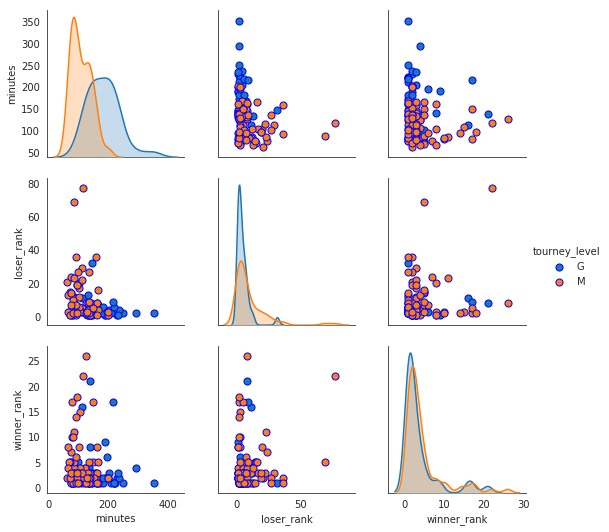

In [5]:
# Use pairplot to draw multiple variables at once
df_pp = tennis_df[tennis_df['tourney_year'].between(2010,2019)&tennis_df['tourney_level'].isin(['M','G'])&tennis_df['round'].isin(['F'])][['minutes','loser_rank','winner_rank','tourney_level']].dropna()
sns.pairplot(df_pp, hue='tourney_level',diag_kind="kde", plot_kws=dict(s=50, edgecolor="b", linewidth=1), diag_kws=dict(shade=True))

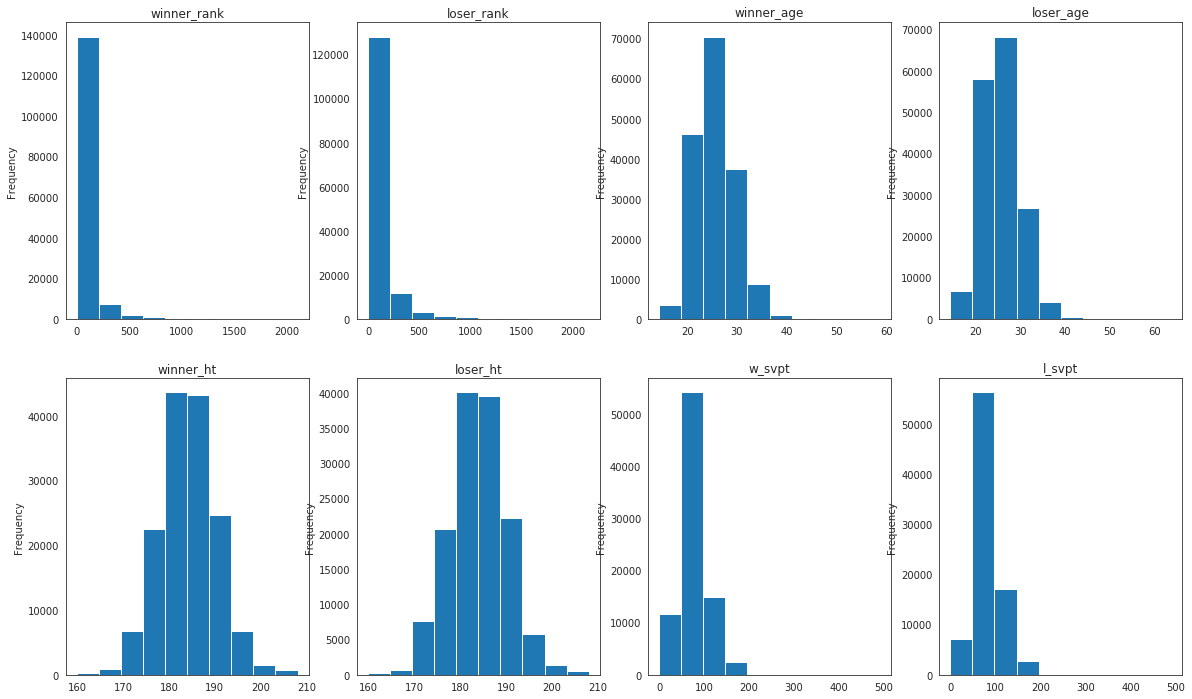

In [6]:
dimensions = ['winner_rank','loser_rank','winner_age','loser_age','winner_ht','loser_ht','w_svpt','l_svpt']

plt.figure(1, figsize=(20,12))

for i in range(1,9):
    plt.subplot(2,4,i)
    tennis_df[dimensions[i-1]].plot(kind='hist', title=dimensions[i-1])

## Distribution of aces by surface type
What is the distribution of aces by the different type of surfaces? 

[Text(0, 0.5, 'Aces'), Text(0.5, 0, 'Surface')]

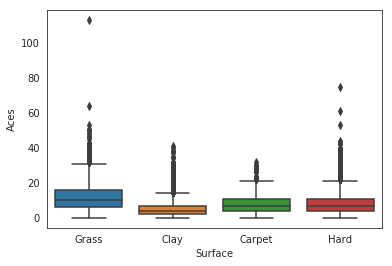

In [7]:
tennis_df_h = tennis_df[tennis_df['tourney_level'].astype(str).isin(['G','M'])].copy()
tennis_df_h['w_ace'] = tennis_df_h['w_ace'].astype(float)
g = sns.boxplot(x="surface", y="w_ace", data=tennis_df_h)
g.set(xlabel='Surface', ylabel='Aces')

We can see in this boxplot that **grass and hard courts have a higher incidence of aces** as compared to clay courts

## Evolution of top countries represented by their players

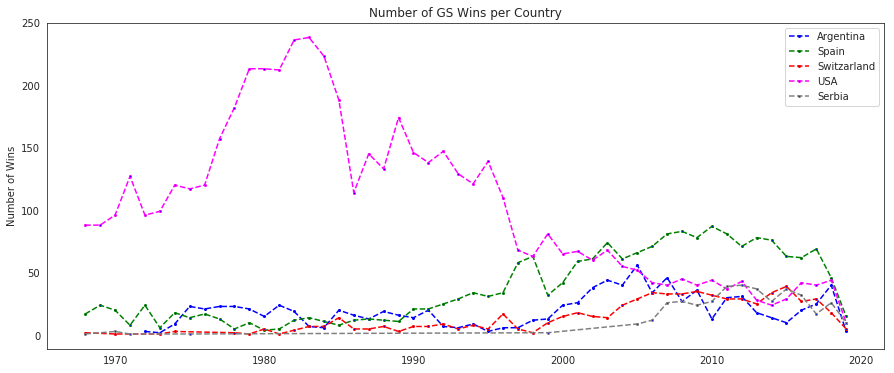

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))

s = tennis_df[(tennis_df['tourney_level'] == 'G') & (tennis_df['winner_ioc'].isin(['ARG']))].groupby(['tourney_year','winner_ioc']).agg('count')
plt.plot(s['tourney_id'].index.get_level_values(0), s['tourney_id'].values, color='blue', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=2, label='Argentina')

s = tennis_df[(tennis_df['tourney_level'] == 'G') & (tennis_df['winner_ioc'].isin(['ESP']))].groupby(['tourney_year','winner_ioc']).agg('count')
plt.plot(s['tourney_id'].index.get_level_values(0), s['tourney_id'].values, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=2, label='Spain')

s = tennis_df[(tennis_df['tourney_level'] == 'G') & (tennis_df['winner_ioc'].isin(['SUI']))].groupby(['tourney_year','winner_ioc']).agg('count')
ax.plot(s['tourney_id'].index.get_level_values(0), s['tourney_id'].values, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=2, label='Switzarland')

s = tennis_df[(tennis_df['tourney_level'] == 'G') & (tennis_df['winner_ioc'].isin(['USA']))].groupby(['tourney_year','winner_ioc']).agg('count')
ax.plot(s['tourney_id'].index.get_level_values(0), s['tourney_id'].values, color='magenta', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=2, label='USA')

s = tennis_df[(tennis_df['tourney_level'] == 'G') & (tennis_df['winner_ioc'].isin(['SRB']))].groupby(['tourney_year','winner_ioc']).agg('count')
ax.plot(s['tourney_id'].index.get_level_values(0), s['tourney_id'].values, color='grey', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=2, label='Serbia')

#labels = s.index.get_level_values(0)

ax.set_ylabel('Number of Wins')
ax.set_title('Number of GS Wins per Country')
#ax.set_xticklabels(labels)
ax.legend()

There is an **increase in the number of wins from players from Argentina since the early 2000s**

There is an **increase in the number of wins in the cases of Spain, Switzerland and Serbia** (New top players —> Nadal, Federer and Djokovic)

## Top most aces, double faults and break points saved

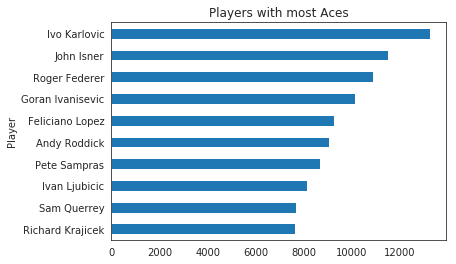

In [9]:
sw = tennis_df.groupby(['winner_name']).agg({'w_ace':'sum'}).fillna(0).sort_values(['w_ace'], ascending=False)
sl = tennis_df.groupby(['loser_name']).agg({'l_ace':'sum'}).fillna(0).sort_values(['l_ace'], ascending=False)
dfs = [sw,sl]
r = pd.concat(dfs, sort=False).reset_index().fillna(0)
r['aces'] = r['l_ace']+r['w_ace']
final = r.groupby('index').agg({'aces':'sum'}).sort_values('aces',ascending=False).head(10)
final = final.reset_index()
final.columns = ['Player','Aces']
final = final.sort_values('Aces',ascending=True)
final.plot('Player','Aces', kind='barh', title='Players with most Aces', legend=False)

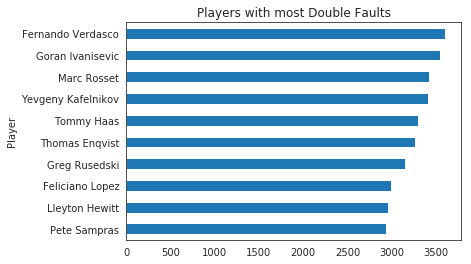

In [10]:
sw = tennis_df.groupby(['winner_name']).agg({'w_df':'sum'}).fillna(0).sort_values(['w_df'], ascending=False)
sl = tennis_df.groupby(['loser_name']).agg({'l_df':'sum'}).fillna(0).sort_values(['l_df'], ascending=False)
dfs = [sw,sl]
r = pd.concat(dfs, sort=False).reset_index().fillna(0)
r['dfs'] = r['l_df']+r['w_df']
final = r.groupby('index').agg({'dfs':'sum'}).sort_values('dfs',ascending=False).head(10)
final = final.reset_index()
final.columns = ['Player','DoubleFaults']
final = final.sort_values('DoubleFaults',ascending=True)
final.plot('Player','DoubleFaults', kind='barh', title='Players with most Double Faults', legend=False)

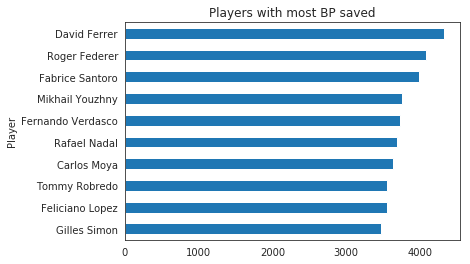

In [11]:
sw = tennis_df.groupby(['winner_name']).agg({'w_bpSaved':'sum'}).fillna(0).sort_values(['w_bpSaved'], ascending=False)
sl = tennis_df.groupby(['loser_name']).agg({'l_bpSaved':'sum'}).fillna(0).sort_values(['l_bpSaved'], ascending=False)
dfs = [sw,sl]
r = pd.concat(dfs, sort=False).reset_index().fillna(0)
r['dfs'] = r['l_bpSaved']+r['w_bpSaved']
final = r.groupby('index').agg({'dfs':'sum'}).sort_values('dfs',ascending=False).head(10)
final = final.reset_index()
final.columns = ['Player','BreakPointsSaved']
final = final.sort_values('BreakPointsSaved',ascending=True)
final.plot('Player','BreakPointsSaved', kind='barh', title='Players with most BP saved', legend=False)

## Evolution of top players in the last 20 years

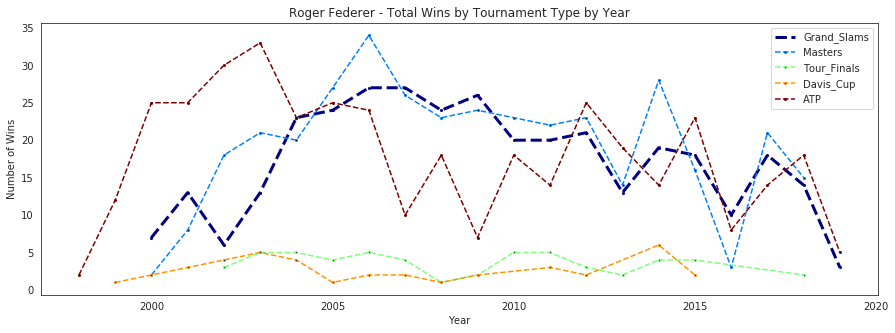

In [12]:
pldf_1 = tennis_df[(tennis_df['winner_name'] == 'Roger Federer')].groupby(['tourney_year','tourney_level'], as_index=False).agg(['count'])
pldf_2 = pldf_1['tourney_id'].reset_index()
pldf_2 = pldf_2.sort_values(by=['tourney_year'])

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 5))))

plt.title('Roger Federer - Total Wins by Tournament Type by Year')
plt.ylabel('Number of Wins')
plt.xlabel('Year')
plt.plot(pldf_2[pldf_2['tourney_level']=='G']['tourney_year'], pldf_2[pldf_2['tourney_level']=='G']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2, linewidth=3)
plt.plot(pldf_2[pldf_2['tourney_level']=='M']['tourney_year'], pldf_2[pldf_2['tourney_level']=='M']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='F']['tourney_year'], pldf_2[pldf_2['tourney_level']=='F']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='D']['tourney_year'], pldf_2[pldf_2['tourney_level']=='D']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='A']['tourney_year'], pldf_2[pldf_2['tourney_level']=='A']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)

plt.legend(['Grand_Slams', 'Masters', 'Tour_Finals', 'Davis_Cup', 'ATP'], loc='upper right', prop={'size': 10})


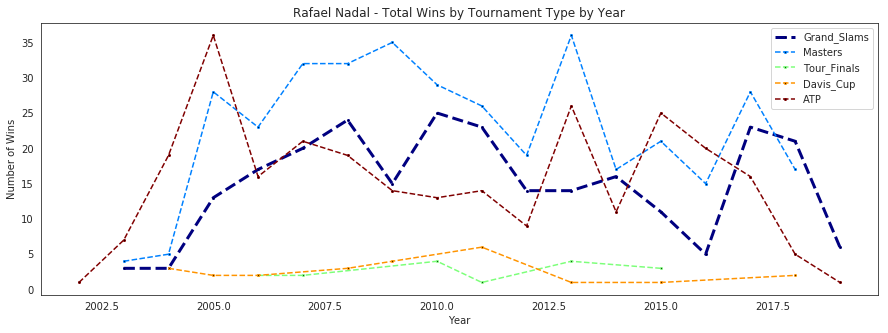

In [13]:
pldf_1 = tennis_df[(tennis_df['winner_name'] == 'Rafael Nadal')].groupby(['tourney_year','tourney_level'], as_index=False).agg(['count'])
pldf_2 = pldf_1['tourney_id'].reset_index()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 5))))

plt.title('Rafael Nadal - Total Wins by Tournament Type by Year')
plt.ylabel('Number of Wins')
plt.xlabel('Year')
plt.plot(pldf_2[pldf_2['tourney_level']=='G']['tourney_year'], pldf_2[pldf_2['tourney_level']=='G']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2, linewidth=3)
plt.plot(pldf_2[pldf_2['tourney_level']=='M']['tourney_year'], pldf_2[pldf_2['tourney_level']=='M']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='F']['tourney_year'], pldf_2[pldf_2['tourney_level']=='F']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='D']['tourney_year'], pldf_2[pldf_2['tourney_level']=='D']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='A']['tourney_year'], pldf_2[pldf_2['tourney_level']=='A']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)

plt.legend(['Grand_Slams', 'Masters', 'Tour_Finals', 'Davis_Cup', 'ATP'], loc='upper right')

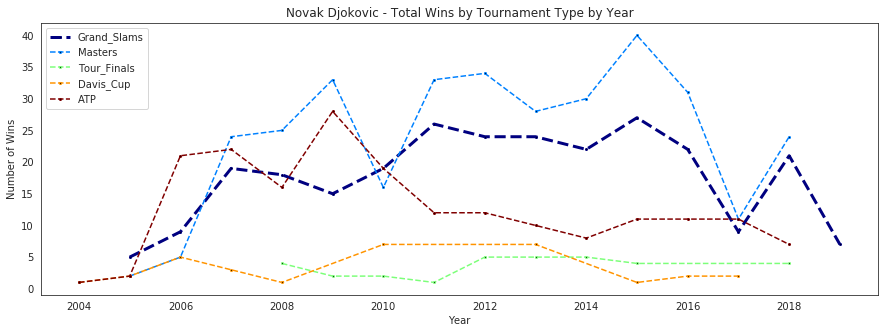

In [14]:
pldf_1 = tennis_df[(tennis_df['winner_name'] == 'Novak Djokovic')].groupby(['tourney_year','tourney_level'], as_index=False).agg(['count'])
pldf_2 = pldf_1['tourney_id'].reset_index()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 5))))

plt.title('Novak Djokovic - Total Wins by Tournament Type by Year')
plt.ylabel('Number of Wins')
plt.xlabel('Year')
plt.plot(pldf_2[pldf_2['tourney_level']=='G']['tourney_year'], pldf_2[pldf_2['tourney_level']=='G']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2, linewidth=3)
plt.plot(pldf_2[pldf_2['tourney_level']=='M']['tourney_year'], pldf_2[pldf_2['tourney_level']=='M']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='F']['tourney_year'], pldf_2[pldf_2['tourney_level']=='F']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='D']['tourney_year'], pldf_2[pldf_2['tourney_level']=='D']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)
plt.plot(pldf_2[pldf_2['tourney_level']=='A']['tourney_year'], pldf_2[pldf_2['tourney_level']=='A']['count'], linestyle='dashed', marker='o', markerfacecolor='black', markersize=2)

plt.legend(['Grand_Slams', 'Masters', 'Tour_Finals', 'Davis_Cup', 'ATP'], loc='upper left')

## Dominance: Unique number of players that won most important tournaments

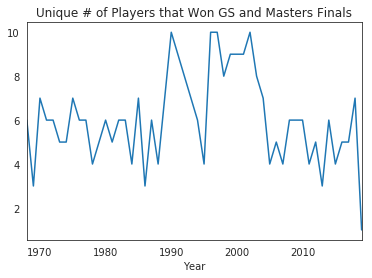

In [15]:
# Unique number of tournament winner per year from 2000 to 2016 (show dominance of top players)
s = tennis_df[(tennis_df['round']=='F')&(tennis_df['tourney_level'].isin(['M','G']))].groupby(['tourney_year']).agg({'winner_name':'nunique'})
t= s.reset_index()
t.columns=['Year','Unique_Winners']
t.plot('Year', 'Unique_Winners', title='Unique # of Players that Won GS and Masters Finals', legend=False)

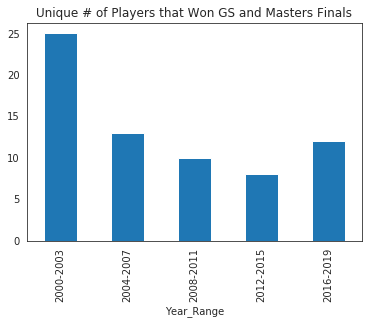

In [16]:
# Unique number of tournament winner per year from 2000 to 2016 (show dominance of top players)
s = tennis_df[(tennis_df['round']=='F')&(tennis_df['tourney_level'].isin(['M','G']))&(tennis_df['tourney_year'].between(2000,2003))].agg({'winner_name':'nunique'})
t = tennis_df[(tennis_df['round']=='F')&(tennis_df['tourney_level'].isin(['M','G']))&(tennis_df['tourney_year'].between(2004,2007))].agg({'winner_name':'nunique'})
u = tennis_df[(tennis_df['round']=='F')&(tennis_df['tourney_level'].isin(['M','G']))&(tennis_df['tourney_year'].between(2008,2011))].agg({'winner_name':'nunique'})
v = tennis_df[(tennis_df['round']=='F')&(tennis_df['tourney_level'].isin(['M','G']))&(tennis_df['tourney_year'].between(2012,2015))].agg({'winner_name':'nunique'})
w = tennis_df[(tennis_df['round']=='F')&(tennis_df['tourney_level'].isin(['M','G']))&(tennis_df['tourney_year'].between(2016,2019))].agg({'winner_name':'nunique'})

s['2000-2003'] = s['winner_name']
s=s.drop('winner_name')
t['2004-2007'] = t['winner_name']
t=t.drop('winner_name')
u['2008-2011'] = u['winner_name']
u=u.drop('winner_name')
v['2012-2015'] = v['winner_name']
v=v.drop('winner_name')
w['2016-2019'] = w['winner_name']
w=w.drop('winner_name')

dfl = [s,t,u,v,w]
dfs = pd.concat(dfl)
x=pd.DataFrame(dfs, columns=['Unique_Count']).reset_index()
x.columns=['Year_Range','Unique_Winners']
x.plot('Year_Range', 'Unique_Winners', kind='bar', title='Unique # of Players that Won GS and Masters Finals', legend=False)


## Relationship between Aces and Height of players

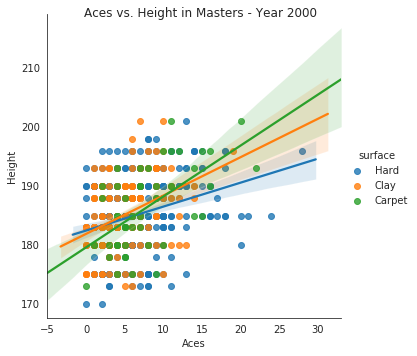

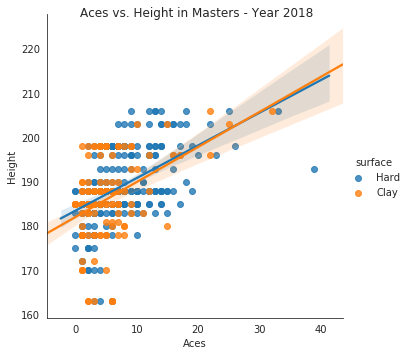

In [17]:

g1 = sns.lmplot(x='w_ace', y='winner_ht', hue='surface', fit_reg=True, data=tennis_df[(tennis_df['tourney_level'].isin(['M']))&(tennis_df['tourney_year']==2000)])
g1.fig.suptitle('Aces vs. Height in Masters - Year 2000') 
g1.set(xlabel='Aces', ylabel='Height')

g2 = sns.lmplot(x='w_ace', y='winner_ht', hue='surface', fit_reg=True, data=tennis_df[(tennis_df['tourney_level'].isin(['M']))&(tennis_df['tourney_year']==2018)])
g2.fig.suptitle('Aces vs. Height in Masters - Year 2018')
g2.set(xlabel='Aces', ylabel='Height')




When comparing 2018 to 2000 scatter plots we notice that in recent years there is a higher relation of aces to the height of the players
The number of taller players with more aces have also increased

## Effectiveness of top players by surface type

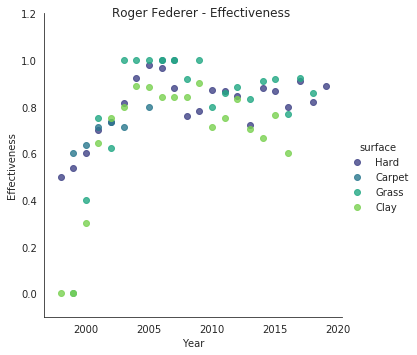

In [18]:
pw = tennis_df[(tennis_df['winner_name'] == 'Roger Federer')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pww = pw['tourney_id'].reset_index()

pl = tennis_df[(tennis_df['loser_name'] == 'Roger Federer')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pll = pl['tourney_id'].reset_index()

pww.columns = ['tourney_year','surface','wins']
pll.columns = ['tourney_year','surface','loses']

dfs = (pww,pll)

dfs_concat = pd.concat(dfs, sort=False)

dfs_final = dfs_concat.fillna(0).groupby(['tourney_year','surface']).agg({'wins':'sum','loses':'sum'}).reset_index()

dfs_final['r_eff'] = np.where(dfs_final['loses']>0, dfs_final['wins']/(dfs_final['wins']+dfs_final['loses']), 1)
dfs_final['tourney_year'] = dfs_final['tourney_year'].astype(int)

#sns.swarmplot(x="tourney_year", y="r_eff", hue="surface", data=dfs_final);

g = sns.lmplot(x='tourney_year', y='r_eff', hue='surface', fit_reg=False, data=dfs_final, palette='viridis', hue_order=['Hard','Carpet','Grass','Clay'])
#sns.barplot(x="tourney_year", y="r_eff", hue="surface", data=dfs_final)
g.fig.suptitle('Roger Federer - Effectiveness')
g.set(xlabel='Year', ylabel='Effectiveness')
g.set(ylim=(-0.1,1.2))

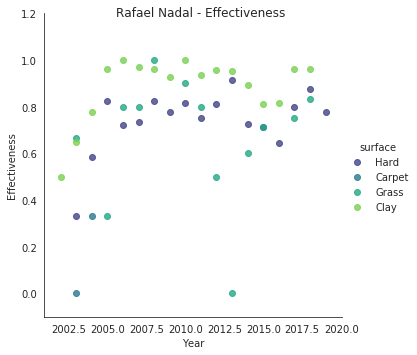

In [19]:
pw = tennis_df[(tennis_df['winner_name'] == 'Rafael Nadal')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pww = pw['tourney_id'].reset_index()

pl = tennis_df[(tennis_df['loser_name'] == 'Rafael Nadal')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pll = pl['tourney_id'].reset_index()

pww.columns = ['tourney_year','surface','wins']
pll.columns = ['tourney_year','surface','loses']

dfs = (pww,pll)

dfs_concat = pd.concat(dfs, sort=False)

dfs_final = dfs_concat.fillna(0).groupby(['tourney_year','surface']).agg({'wins':'sum','loses':'sum'}).reset_index()

dfs_final['r_eff'] = np.where(dfs_final['loses']>0, dfs_final['wins']/(dfs_final['wins']+dfs_final['loses']), 1)
dfs_final['tourney_year'] = dfs_final['tourney_year'].astype(int)

g = sns.lmplot(x='tourney_year', y='r_eff', hue='surface', fit_reg=False, data=dfs_final, palette='viridis', hue_order=['Hard','Carpet','Grass','Clay'])
g.fig.suptitle('Rafael Nadal - Effectiveness')
g.set(xlabel='Year', ylabel='Effectiveness')
g.set(ylim=(-0.1,1.2))

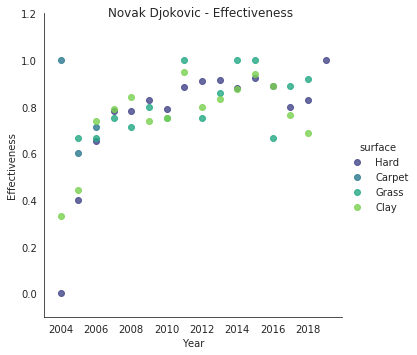

In [20]:
pw = tennis_df[(tennis_df['winner_name'] == 'Novak Djokovic')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pww = pw['tourney_id'].reset_index()

pl = tennis_df[(tennis_df['loser_name'] == 'Novak Djokovic')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pll = pl['tourney_id'].reset_index()

pww.columns = ['tourney_year','surface','wins']
pll.columns = ['tourney_year','surface','loses']

dfs = (pww,pll)

dfs_concat = pd.concat(dfs, sort=False)

dfs_final = dfs_concat.fillna(0).groupby(['tourney_year','surface']).agg({'wins':'sum','loses':'sum'}).reset_index()

dfs_final['r_eff'] = np.where(dfs_final['loses']>0, dfs_final['wins']/(dfs_final['wins']+dfs_final['loses']), 1)
dfs_final['tourney_year'] = dfs_final['tourney_year'].astype(int)

g = sns.lmplot(x='tourney_year', y='r_eff', hue='surface', fit_reg=False, data=dfs_final, palette='viridis', hue_order=['Hard','Carpet','Grass','Clay'])
g.fig.suptitle('Novak Djokovic - Effectiveness')
g.set(xlabel='Year', ylabel='Effectiveness')
g.set(ylim=(-0.1,1.2))

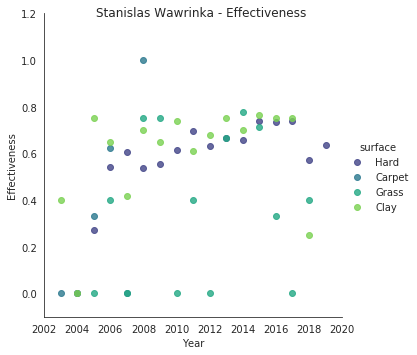

In [21]:
pw = tennis_df[(tennis_df['winner_name'] == 'Stanislas Wawrinka')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pww = pw['tourney_id'].reset_index()

pl = tennis_df[(tennis_df['loser_name'] == 'Stanislas Wawrinka')].groupby(['tourney_year','surface'], as_index=False).agg(['count'])
pll = pl['tourney_id'].reset_index()

pww.columns = ['tourney_year','surface','wins']
pll.columns = ['tourney_year','surface','loses']

dfs = (pww,pll)

dfs_concat = pd.concat(dfs, sort=False)

dfs_final = dfs_concat.fillna(0).groupby(['tourney_year','surface']).agg({'wins':'sum','loses':'sum'}).reset_index()

dfs_final['r_eff'] = np.where(dfs_final['loses']>0, dfs_final['wins']/(dfs_final['wins']+dfs_final['loses']), 1)
dfs_final['tourney_year'] = dfs_final['tourney_year'].astype(int)

g = sns.lmplot(x='tourney_year', y='r_eff', hue='surface', fit_reg=False, data=dfs_final, palette='viridis', hue_order=['Hard','Carpet','Grass','Clay'])
g.fig.suptitle('Stanislas Wawrinka - Effectiveness')
g.set(xlabel='Year', ylabel='Effectiveness')
g.set(ylim=(-0.1,1.2))


# Analysis from 1968 to 2019

([<matplotlib.axis.XTick at 0x7f6156773198>,
 <a list of 11 Text xticklabel objects>)

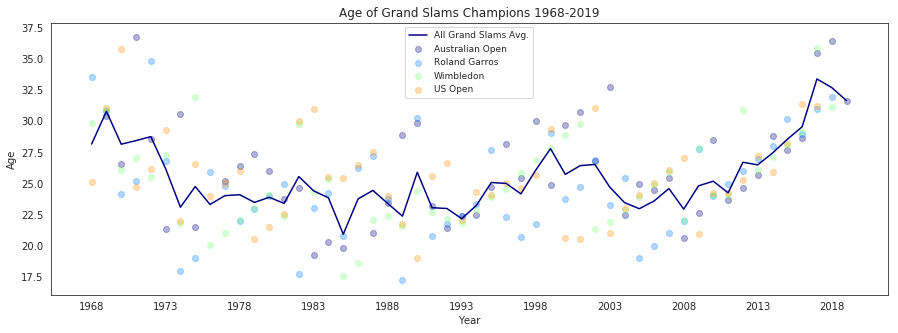

In [22]:
# What is the average age of Grand Slams' players from 1968 up to 2019?
tennis_df_win=tennis_df[tennis_df['tourney_level'].isin(['G'])&(tennis_df['round']=='F')].dropna(subset=['winner_age'])
dfw = tennis_df_win[['tourney_year','tourney_name','winner_name','winner_age']]
dfw.columns = ['tourney_year','tourney_name','player','age']

dfs_final = dfw.groupby(['tourney_year','tourney_name']).agg({'age':'mean'}).reset_index()
dfs_final_2 = dfs_final.groupby(['tourney_year']).agg({'age':'mean'}).reset_index()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 5))))

plt.title('Age of Grand Slams Champions 1968-2019')
plt.ylabel('Age')
plt.xlabel('Year')

plt.plot(dfs_final_2['tourney_year'], dfs_final_2['age'])
plt.scatter(dfs_final[dfs_final['tourney_name']=='Australian Open']['tourney_year'], dfs_final[dfs_final['tourney_name']=='Australian Open']['age'], alpha=0.3)
plt.scatter(dfs_final[dfs_final['tourney_name']=='Roland Garros']['tourney_year'], dfs_final[dfs_final['tourney_name']=='Roland Garros']['age'], alpha=0.3)
plt.scatter(dfs_final[dfs_final['tourney_name']=='Wimbledon']['tourney_year'], dfs_final[dfs_final['tourney_name']=='Wimbledon']['age'], alpha=0.3)
plt.scatter(dfs_final[dfs_final['tourney_name']=='US Open']['tourney_year'], dfs_final[dfs_final['tourney_name']=='US Open']['age'], alpha=0.3)

plt.legend(['All Grand Slams Avg.','Australian Open', 'Roland Garros', 'Wimbledon', 'US Open'], loc='upper center',prop={'size': 9})
plt.xticks(np.arange(1968, 2019, 5), np.arange(1968, 2019, 5))

## Retirements
** What is the evolution of retirements over time? In which tournament we see most of these retirements? **

([<matplotlib.axis.XTick at 0x7f61544022e8>,
 <a list of 10 Text xticklabel objects>)

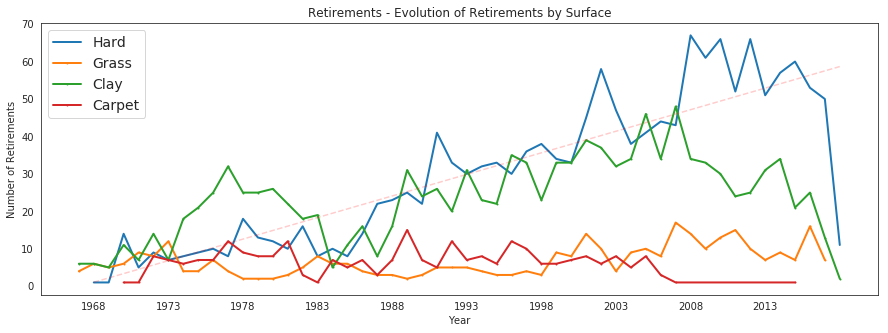

In [23]:
# Extract retirements
ret_df = tennis_df[tennis_df['score'].str.contains("RET")==True][['tourney_year','tourney_level','surface','tourney_id','winner_name']]
ref_df_f = ret_df.groupby(['tourney_year','surface'], as_index=False).agg('count')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.style.use('seaborn-colorblind')

plt.title('Retirements - Evolution of Retirements by Surface')
plt.ylabel('Number of Retirements')
plt.xlabel('Year')
plt.plot(ref_df_f[ref_df_f['surface']=='Hard']['tourney_year'], ref_df_f[ref_df_f['surface']=='Hard']['tourney_id'], linestyle='solid', linewidth=2)
plt.plot(ref_df_f[ref_df_f['surface']=='Grass']['tourney_year'], ref_df_f[ref_df_f['surface']=='Grass']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=2)
plt.plot(ref_df_f[ref_df_f['surface']=='Clay']['tourney_year'], ref_df_f[ref_df_f['surface']=='Clay']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=2)
plt.plot(ref_df_f[ref_df_f['surface']=='Carpet']['tourney_year'], ref_df_f[ref_df_f['surface']=='Carpet']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=2)

# Calc the trendline for hard court
x = ref_df_f[ref_df_f['surface']=='Hard']['tourney_year'].astype(int)
y = ref_df_f[ref_df_f['surface']=='Hard']['tourney_id'].astype(int)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x),"r--", alpha=0.2)

plt.legend(['Hard', 'Grass', 'Clay', 'Carpet'], loc='upper left', prop={'size': 14})
plt.xticks(np.arange(1969, 2019, 5), np.arange(1968, 2019, 5))

### ** Do the retirements by tournament type have the same behaviour? **

([<matplotlib.axis.XTick at 0x7f61543704a8>,
 <a list of 11 Text xticklabel objects>)

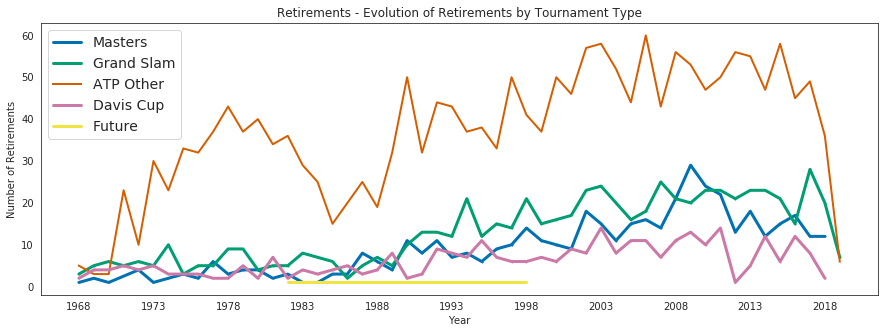

In [24]:
ref_df_f = ret_df.groupby(['tourney_year','tourney_level'], as_index=False).agg('count')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.style.use('seaborn-colorblind')

plt.title('Retirements - Evolution of Retirements by Tournament Type')
plt.ylabel('Number of Retirements')
plt.xlabel('Year')
plt.plot(ref_df_f[ref_df_f['tourney_level']=='M']['tourney_year'], ref_df_f[ref_df_f['tourney_level']=='M']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)
plt.plot(ref_df_f[ref_df_f['tourney_level']=='G']['tourney_year'], ref_df_f[ref_df_f['tourney_level']=='G']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)
plt.plot(ref_df_f[ref_df_f['tourney_level']=='A']['tourney_year'], ref_df_f[ref_df_f['tourney_level']=='A']['tourney_id'], linestyle='solid', linewidth=2, solid_capstyle='projecting')
plt.plot(ref_df_f[ref_df_f['tourney_level']=='D']['tourney_year'], ref_df_f[ref_df_f['tourney_level']=='D']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)
plt.plot(ref_df_f[ref_df_f['tourney_level']=='F']['tourney_year'], ref_df_f[ref_df_f['tourney_level']=='F']['tourney_id'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)

plt.legend(['Masters','Grand Slam', 'ATP Other', 'Davis Cup', 'Future'], loc='upper left', prop={'size': 14})
plt.xticks(np.arange(1968, 2019, 5), np.arange(1968, 2019, 5))

### ** Is is just that we have more retirements because there are more matches played in that tournament or surface? What if we consider the ratio of retirements over matches played? **

([<matplotlib.axis.XTick at 0x7f61542f6be0>,
 <a list of 11 Text xticklabel objects>)

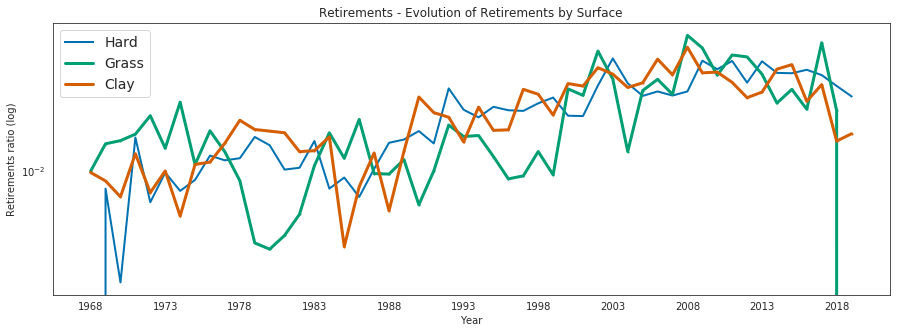

In [25]:
ret_df_f = ret_df.groupby(['tourney_year','surface'], as_index=False).agg('count')[['tourney_year','surface','tourney_id']]
ret_df_f.columns = ['tourney_year','surface','rets']

notret_df = tennis_df[tennis_df['score'].str.contains("RET")==False][['tourney_year','surface','tourney_id']]
notret_df_f = notret_df.groupby(['tourney_year','surface'], as_index=False).agg('count')[['tourney_year','surface','tourney_id']]
notret_df_f.columns = ['tourney_year','surface','norets']

dfs = (ret_df_f, notret_df_f)
dfs_concat = pd.concat(dfs, sort=False)

dfs_c = dfs_concat.fillna(0).groupby(['tourney_year','surface']).agg({'rets':'sum','norets':'sum'}).reset_index()

dfs_c['ret_ratio'] = np.where(dfs_c['norets']>0, dfs_c['rets']/(dfs_c['rets']+dfs_c['norets']), 1)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.style.use('seaborn-colorblind')

plt.title('Retirements - Evolution of Retirements by Surface')
plt.yscale('log') # Using log scale
plt.ylabel('Retirements ratio (log)')
plt.xlabel('Year')


plt.plot(dfs_c[dfs_c['surface']=='Hard']['tourney_year'], dfs_c[dfs_c['surface']=='Hard']['ret_ratio'], linestyle='solid', linewidth=2, solid_capstyle='projecting')
plt.plot(dfs_c[dfs_c['surface']=='Grass']['tourney_year'], dfs_c[dfs_c['surface']=='Grass']['ret_ratio'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)
plt.plot(dfs_c[dfs_c['surface']=='Clay']['tourney_year'], dfs_c[dfs_c['surface']=='Clay']['ret_ratio'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)

plt.legend(['Hard','Grass', 'Clay'], loc='upper left', prop={'size': 14})

plt.xticks(np.arange(1968, 2019, 5), np.arange(1968, 2019, 5))

### ** We can see there is a growth in retirements over the years. The growth seems to happen across surfaces. Does it also happen across tournament types? **

([<matplotlib.axis.XTick at 0x7f615419ff98>,
 <a list of 10 Text xticklabel objects>)

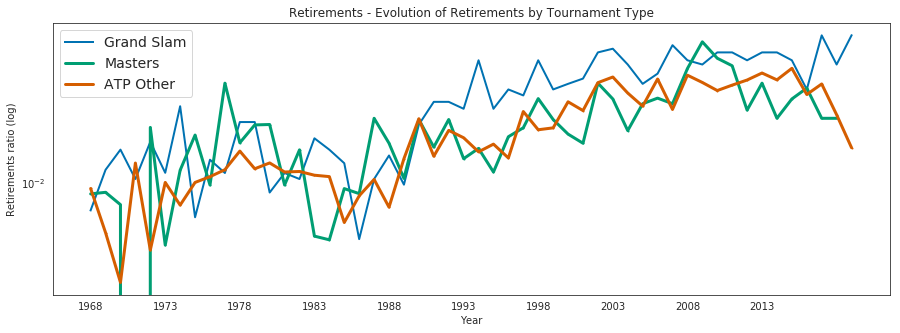

In [26]:
ret_df_f = ret_df.groupby(['tourney_year','tourney_level'], as_index=False).agg('count')[['tourney_year','tourney_level','tourney_id']]
ret_df_f.columns = ['tourney_year','tourney_level','rets']

notret_df = tennis_df[tennis_df['score'].str.contains("RET")==False][['tourney_year','tourney_level','tourney_id']]
notret_df_f = notret_df.groupby(['tourney_year','tourney_level'], as_index=False).agg('count')[['tourney_year','tourney_level','tourney_id']]
notret_df_f.columns = ['tourney_year','tourney_level','norets']

dfs = (ret_df_f, notret_df_f)
dfs_concat = pd.concat(dfs, sort=False)

dfs_c = dfs_concat.fillna(0).groupby(['tourney_year','tourney_level']).agg({'rets':'sum','norets':'sum'}).reset_index()

dfs_c['ret_ratio'] = np.where(dfs_c['norets']>0, dfs_c['rets']/(dfs_c['rets']+dfs_c['norets']), 1)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.style.use('seaborn-colorblind')

plt.title('Retirements - Evolution of Retirements by Tournament Type')
plt.yscale('log') # Using log scale
plt.ylabel('Retirements ratio (log)')
plt.xlabel('Year')

plt.plot(dfs_c[dfs_c['tourney_level']=='G']['tourney_year'], dfs_c[dfs_c['tourney_level']=='G']['ret_ratio'], linestyle='solid', linewidth=2, solid_capstyle='projecting')
plt.plot(dfs_c[dfs_c['tourney_level']=='M']['tourney_year'], dfs_c[dfs_c['tourney_level']=='M']['ret_ratio'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)
plt.plot(dfs_c[dfs_c['tourney_level']=='A']['tourney_year'], dfs_c[dfs_c['tourney_level']=='A']['ret_ratio'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)

plt.legend(['Grand Slam','Masters', 'ATP Other'], loc='upper left', prop={'size': 14})

plt.xticks(np.arange(1968, 2016, 5), np.arange(1968, 2016, 5))

If we look at the retirements ratio by tournament type we can see there has been a **higher ratio of retirements in Grand Slams comparing to Masters and other ATP tournaments since the 1990s. **

We can see that the number of retirements effectively increased since the 1990s, but why? **Tennis has become more physical and competitive over the years** and that has had an impact in players' endurance and increase the probability of injuries. Considering this, older players are more prone to retire. 

** One way of validating this is checking if there is a relation between the retirements and the age of the player that retired. Let's check. **

([<matplotlib.axis.XTick at 0x7f61540e4b38>,
 <a list of 11 Text xticklabel objects>)

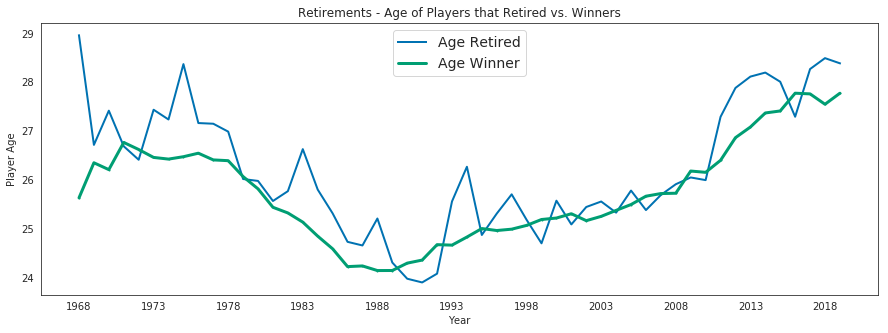

In [27]:
#df_minutes = tennis_df_all[pd.isnull(tennis_df_all['minutes'])==False]
df_ret_age = tennis_df[tennis_df['score'].str.contains("RET")==True].groupby(['tourney_year']).agg({'loser_age':'mean'}).reset_index()
df_ret_age.columns = ['tourney_year','age_ret']

df_notret_age = tennis_df[tennis_df['score'].str.contains("RET")==False].groupby(['tourney_year']).agg({'loser_age':'mean'}).reset_index()
df_notret_age.columns = ['tourney_year','age_notret']

df_age_all = df_ret_age.merge(df_notret_age, on='tourney_year', how='left')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.style.use('seaborn-colorblind')

plt.title('Retirements - Age of Players that Retired vs. Winners')
plt.ylabel('Player Age')
plt.xlabel('Year')

plt.plot(df_age_all['tourney_year'], df_age_all['age_ret'], linestyle='solid', linewidth=2, solid_capstyle='projecting')
plt.plot(df_age_all['tourney_year'], df_age_all['age_notret'], linestyle='solid', marker='o', markerfacecolor='black', markersize=1, linewidth=3)

plt.legend(['Age Retired','Age Winner'], loc='upper center', prop={'size': 14})
plt.xticks(np.arange(1968, 2019, 5), np.arange(1968, 2019, 5))

### ** If we look at countries with the most matches in the ATP, which ones are the ones with the highest retirements' ratio? **

[Text(0, 0.5, 'Ret. Ratio'),
 Text(0.5, 0, 'Country'),
 Text(0.5, 1.0, 'Highest Retirement Ratio by Country')]

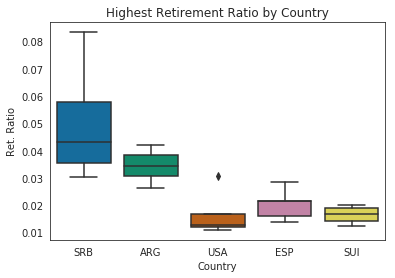

In [28]:
df_ret_cntry = tennis_df[tennis_df['score'].str.contains("RET")==True].groupby(['loser_ioc','tourney_level']).agg('count').reset_index()[['loser_ioc','tourney_level','tourney_id']]
df_ret_cntry.columns = ['country','tourney_level','total_ret']

df_notret_cntry = tennis_df[tennis_df['score'].str.contains("RET")==False].groupby(['loser_ioc','tourney_level']).agg('count').reset_index()[['loser_ioc','tourney_level','tourney_id']]
df_notret_cntry.columns = ['country','tourney_level','total_noret']

df_cntry_all = df_ret_cntry.merge(df_notret_cntry, on=['country','tourney_level'], how='left')

df_cntry_all['ret_ratio'] = df_cntry_all['total_ret']/(df_cntry_all['total_noret']+df_cntry_all['total_ret'])
df_cntry_final = df_cntry_all[df_cntry_all['country'].isin(['ARG','ESP','USA','SUI','SRB'])].sort_values(['ret_ratio'], ascending=False)

ax=sns.boxplot(x="country", y="ret_ratio", data=df_cntry_final)
ax.set(xlabel='Country', ylabel='Ret. Ratio', title='Highest Retirement Ratio by Country')



### ** Who are the players that retired the most? Not looking at ratios here, just the total number of retirements **

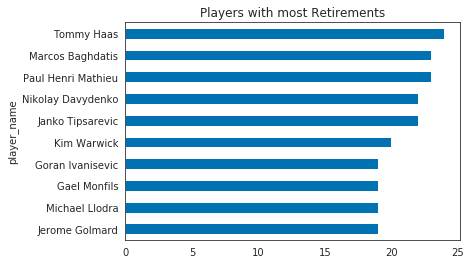

In [29]:
df_ret_players = tennis_df[tennis_df['score'].str.contains("RET")==True].groupby(['loser_name','loser_ioc']).agg('count').reset_index()[['loser_name','loser_ioc','tourney_id']]
df_ret_players.columns = ['player_name','country','total_ret']
df_ret_players = df_ret_players.sort_values(['total_ret'],ascending=False).head(10)

df_ret_players_sorted = df_ret_players.sort_values(['total_ret'],ascending=True)
df_ret_players_sorted.plot('player_name','total_ret', kind='barh', title='Players with most Retirements', legend=False)


### ** What about the players that played the most matches and never retired from a match? What was their winning ratio? **

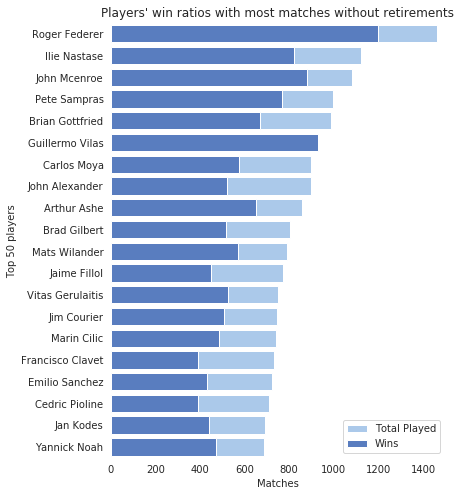

In [30]:
# Wins for each player
df_win_players = tennis_df.groupby(['winner_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['winner_name','tourney_id','tourney_year']]
df_win_players.columns = ['player_name','total_won','tourney_year']
df_win_players['year_period'] = pd.cut(df_win_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s','2010s'])

# Loses for each player
df_lost_players = tennis_df.groupby(['loser_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['loser_name','tourney_id','tourney_year']]
df_lost_players.columns = ['player_name','total_lost','tourney_year']
df_lost_players['year_period'] = pd.cut(df_lost_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s', '2010s'])

# Retirements for each player
df_ret_players = tennis_df[tennis_df['score'].str.contains("RET")==True].groupby(['loser_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['loser_name','tourney_id','tourney_year']]
df_ret_players.columns = ['player_name','total_ret','tourney_year']
df_ret_players['year_period'] = pd.cut(df_ret_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s', '2010s'])

# Concatenate data frames
dfs_players = (df_win_players, df_lost_players, df_ret_players)
dfs_players_concat = pd.concat(dfs_players, sort=False)

# Group by player name and year period
dfs_players_final = dfs_players_concat.groupby(['player_name','year_period']).agg({'total_won':'sum','total_lost':'sum','total_ret':'sum'}).fillna(0).reset_index()

dfs_players_final['total_played'] = dfs_players_final['total_won']+dfs_players_final['total_lost']+dfs_players_final['total_ret']
dfs_players_final['win_ratio'] = dfs_players_final['total_won']/(dfs_players_final['total_won']+dfs_players_final['total_lost']+dfs_players_final['total_ret'])

dfs_players_top = dfs_players_final[dfs_players_final['total_ret']==0].sort_values(['total_played'],ascending=False).head(20)

f, ax = plt.subplots(figsize=(6, 8))

# Plot player names with total matches played
sns.set_color_codes("pastel")
sns.barplot(x="total_played", y="player_name", data=dfs_players_top, 
            label="Total Played", color="b")
               
# Plot player names with total wins
sns.set_color_codes("muted")
sns.barplot(x="total_won", y="player_name", data=dfs_players_top, label="Wins", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 1500), ylabel="Top 50 players",
       xlabel="Matches", title="Players' win ratios with most matches without retirements")
sns.despine(left=True, bottom=True)



### ** All these players are from different time periods. Let's see, how many of the top 10 were actually playing together. ** 

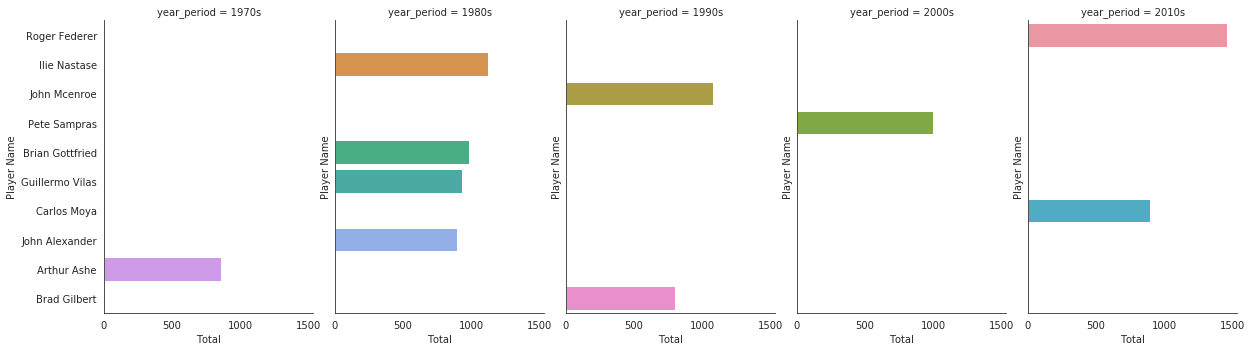

In [31]:
ax=sns.catplot(x="total_played",y="player_name",
                   col="year_period",
                   data=dfs_players_top.head(10), kind="bar",
                   height=5, aspect=.7);
ax.set(xlabel="Total", ylabel="Player Name")

## Longest career spans ##
** Which players have had the longest career spans? At what age did they stop playing? **

Text(0, 0.5, 'Age')

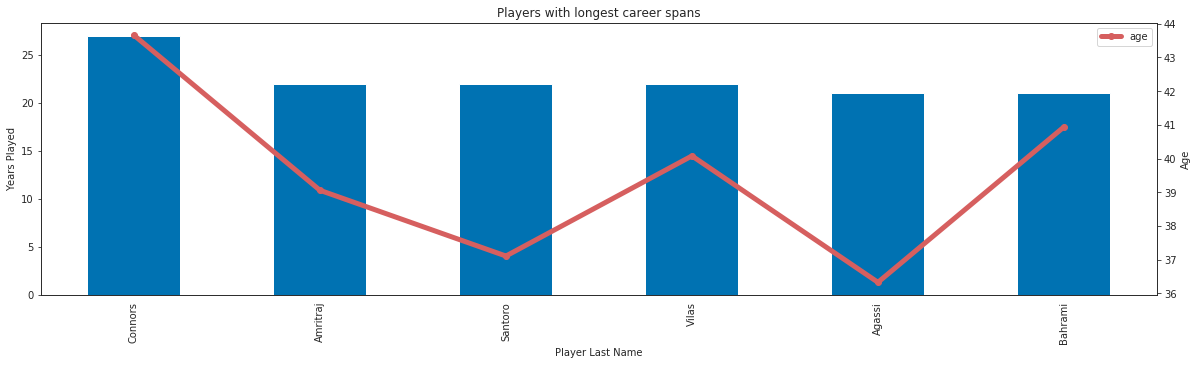

In [32]:
# Calculate age, min and max year for players
df_winnners_bio = tennis_df.groupby(['winner_name']).agg({'winner_age':'max','tourney_year':['min','max']}).reset_index().fillna(0)
df_winnners_bio.columns = ['player_name','age', 'year_min', 'year_max']

df_losers_bio = tennis_df.groupby(['loser_name']).agg({'loser_age':'max','tourney_year':['min','max']}).reset_index().fillna(0)
df_losers_bio.columns = ['player_name','age', 'year_min', 'year_max']

dfs_bio = (df_winnners_bio, df_losers_bio)
dfs_bio_concat = pd.concat(dfs_bio, sort=False)

dfs_bio_final = dfs_bio_concat.groupby(['player_name']).agg({'age':'max','year_min':'min', 'year_max' : 'max'}).reset_index()

# Calculate active years for players
df_winners_years = tennis_df.groupby(['winner_name','tourney_year']).agg({'tourney_id':'count'}).reset_index()#.groupby(['winner_name']).agg({'tourney_year':'count'}).sort_values(['tourney_year'], ascending=False)
df_winners_years.columns = ['player_name','tourney_year','count']

df_losers_years = tennis_df.groupby(['loser_name','tourney_year']).agg({'tourney_id':'count'}).reset_index()#.groupby(['winner_name']).agg({'tourney_year':'count'}).sort_values(['tourney_year'], ascending=False)
df_losers_years.columns = ['player_name','tourney_year','count']

dfs = (df_winners_years, df_losers_years)
dfs_concat = pd.concat(dfs)

df_player_years = dfs_concat.groupby(['player_name','tourney_year']).agg({'tourney_year':'count'}).groupby(['player_name']).agg({'tourney_year':'count'}).reset_index().sort_values(['tourney_year'], ascending=False).head(10)

df_player_final = df_player_years.merge(dfs_bio_final, on='player_name')

# Exclude last year because they may still be playing
df_player_final = df_player_final[df_player_final['year_max'].astype(int) < 2016]

df_player_final['player_lname'] = df_player_final['player_name'].str.split(" ").str.get(1)

f, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

df_player_final.plot(ax=ax2, x='player_lname', y='age', marker='o', color='r', linewidth='5', title='Players with longest career spans')
df_player_final.plot(ax=ax1, x='player_lname', y='tourney_year', kind='bar', legend=False)
ax1.set_xlabel('Player Last Name')
ax1.set_ylabel('Years Played')
ax2.set_ylabel('Age')


## Head to Head ##
** Which players played the most head to head matches per time period? **

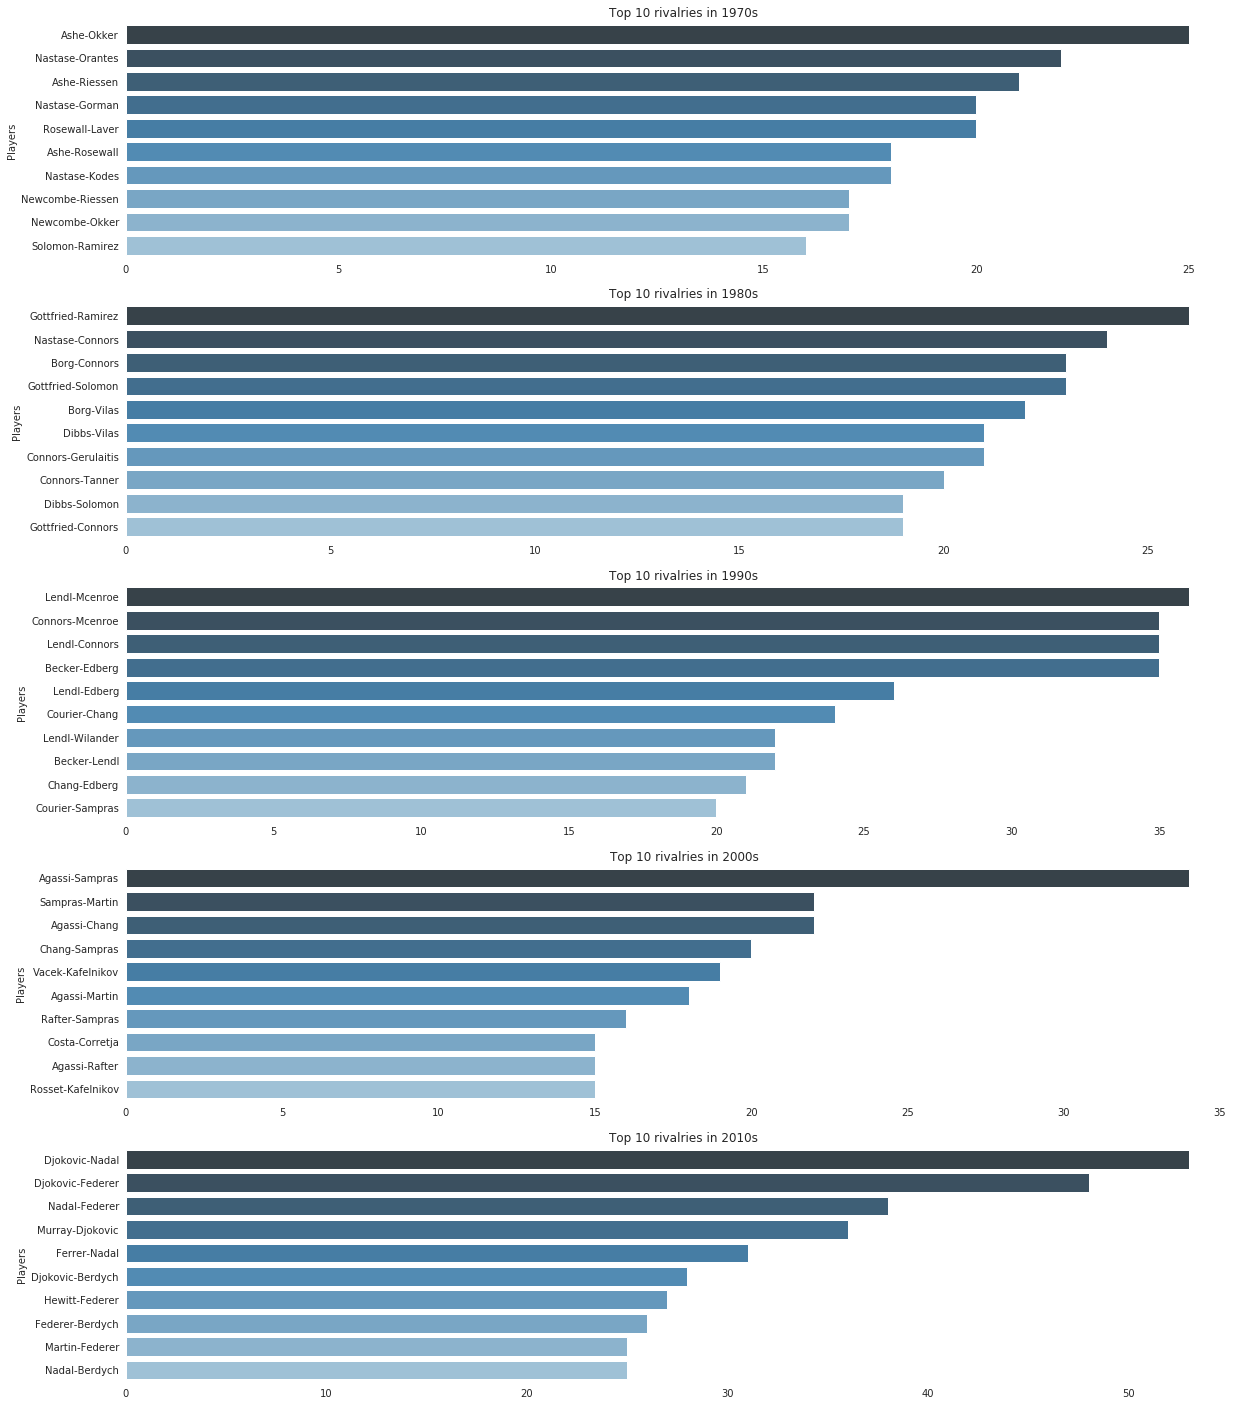

In [33]:
h2h_wl = tennis_df.groupby(['winner_name','loser_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()
h2h_wl.columns = ['player_a','player_b','total','year']

h2h_lw = tennis_df.groupby(['loser_name','winner_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()
h2h_lw.columns = ['player_a','player_b','total','year']

h2h_f = h2h_wl.merge(h2h_lw, on=['player_a', 'player_b'])
h2h_f['total'] = h2h_f['total_x'] + h2h_f['total_y']

h2h_f['player_a'] = np.where(h2h_f['player_a'] < h2h_f['player_b'], h2h_f['player_a'], h2h_f['player_b'])
h2h_f['player_b'] = np.where(h2h_f['player_a'] > h2h_f['player_b'], h2h_f['player_a'], h2h_f['player_b'])
h2h_f['year'] = np.where(h2h_f['year_x'] > h2h_f['year_y'], h2h_f['year_x'], h2h_f['year_y'])
h2h_f['names'] = h2h_f['player_a'].str.split(" ").str.get(1) + "-" + h2h_f['player_b'].str.split(" ").str.get(1)

h2h_f2 = h2h_f.groupby(['player_a','player_b','names']).agg({'total':'max','year':'max'}).reset_index()
h2h_f2_sorted = h2h_f2[h2h_f2['player_a']!=h2h_f2['player_b']].sort_values(['total'], ascending=False)#.head(20)

h2h_f2_sorted['year_period'] = pd.cut(h2h_f2_sorted.year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s', '2010s'])
#h2h_f2_sorted

#f, ax = plt.subplots(figsize=(25, 15))
plt.figure(figsize=(20,25))

plt.subplot(5,1,1)
ax1=sns.barplot(x="total", y="names", palette='Blues_d', data=h2h_f2_sorted[h2h_f2_sorted.year_period=='1970s'].head(10))
ax1.set(xlabel='', ylabel='Players', title='Top 10 rivalries in 1970s')

plt.subplot(5,1,2)
ax2=sns.barplot(x="total", y="names", palette='Blues_d', data=h2h_f2_sorted[h2h_f2_sorted.year_period=='1980s'].head(10))
ax2.set(xlabel='', ylabel='Players', title='Top 10 rivalries in 1980s')

plt.subplot(5,1,3)
ax3=sns.barplot(x="total", y="names", palette='Blues_d', data=h2h_f2_sorted[h2h_f2_sorted.year_period=='1990s'].head(10))
ax3.set(xlabel='', ylabel='Players', title='Top 10 rivalries in 1990s')

plt.subplot(5,1,4)
ax4=sns.barplot(x="total", y="names", palette='Blues_d', data=h2h_f2_sorted[h2h_f2_sorted.year_period=='2000s'].head(10))
ax4.set(xlabel='', ylabel='Players', title='Top 10 rivalries in 2000s')

plt.subplot(5,1,5)
ax5=sns.barplot(x="total", y="names", palette='Blues_d', data=h2h_f2_sorted[h2h_f2_sorted.year_period=='2010s'].head(10))
ax5.set(xlabel='', ylabel='Players', title='Top 10 rivalries in 2010s')

sns.despine(left=True, bottom=True)